In [1]:
# %matplotlib qt5
import matplotlib.pyplot as mplt
import matplotlib.patches as mpach
import matplotlib.transforms as mtrans
import numpy as np
import pandas as pd
import scipy.stats as scystat

# Gaussian Mixture Model

$$ P(x) = \sum_i^N\pi_i\mathcal{N}(\mu_i, \Sigma_i),\quad \mathrm{with} \quad \sum_i^N\pi_i = 1$$

## EM Algorithm

 - 1) Assing $\pi_{i0}, \mu_{i0}, \Sigma_{i0}$

 - 2) For each $ x_j \in \mathcal{D} = \{x_j| j\in[1, p]\}$ calculate

$$r_{ij} = \frac{\pi_{i0}\mathcal{N}(x_j; \mu_{i0}, \Sigma_{i0})}{\sum_i^N\pi_{i0}\mathcal{N}(x_j; \mu_{i0}, \Sigma_{i0})}$$

$$p_i = \sum_j^p r_{ij}$$

 - 3) Update
 
$$\pi_{i1} = \frac{p_i}{p}$$
$$\mu_{i1} = \frac{1}{p_i}\sum_j^p r_{ij}x_j$$
$$\Sigma_{i1} = \frac{1}{p_i}\sum_j^p r_{ij}(x_j-\mu_{i1})(x_j-\mu_{i1})^T$$
 
 - 4) Repeat 2) and 3) until convergence

In [209]:
sigmas_true = [np.eye(2), np.eye(2), np.eye(2)]
mus_true = [np.array([1,2]), np.array([3, -5]), np.array([5, 3])]
clusters = [sig@np.random.randn(2, 200) + mu[:, None] for sig, mu in zip(sigmas_true, mus_true)]
data = np.hstack(clusters)

In [210]:
gauss0 = []
for i in range(len(mus_true)):
    mean = data[:, np.random.randint(0, data.shape[1])]
    cov = 20
#     mean = mus_true[i]
#     cov = sigmas_true[i]
    g = scystat.multivariate_normal(mean=mean, cov=cov, allow_singular=True)
    gauss0.append(g)

In [211]:
parts0 = np.ones(len(gauss0))/len(gauss0)
parts0

array([0.33333333, 0.33333333, 0.33333333])

In [212]:
def iterate_gaussian_mixture_once(data, parts, gauss):
    probs = np.array([g.pdf(data.T) for g in gauss]) * parts[:, None]
    probs /= probs.sum(axis=0)

    mass = probs.sum(axis=1)
    parts = mass / data.shape[1]

    mus = np.array([np.sum(data*prob[None, :], axis=1) for prob in probs])/mass[:, None]
    mus = mus.T

    sigmas = []
    for i, prob in enumerate(probs):
        ddt = data - mus[:, i:i+1]
        sigmas.append((prob[None, :]*ddt) @ ddt.T / mass[i])
    sigmas
    
    gauss_n = []
    for i in range(len(gauss)):
        g = scystat.multivariate_normal(mean=mus[:, i], cov=sigmas[i], allow_singular=True)
        gauss_n.append(g)
    return parts, gauss_n

def confidence_ellipse(gauss, ax, n_std=2.0, ec='tab:blue', **kwargs):
    cov = gauss.cov_object.covariance
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpach.Ellipse(
        (0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
        fc='none', ec=ec, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = gauss.mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = gauss.mean[1]

    transf = mtrans.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse


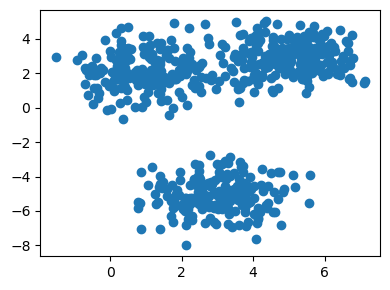

In [255]:
fig, ax = mplt.subplots(1, 1, figsize=(4, 3))

ax.plot(data[0], data[1], 'o')

fig.tight_layout()
# fig.show()

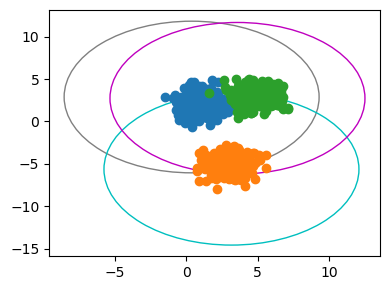

In [213]:
fig, ax = mplt.subplots(1, 1, figsize=(4, 3))

for clt in clusters:
    ax.plot(clt[0], clt[1], 'o')

colors = ['gray', 'c', 'm']
for i, g in enumerate(gauss0):
    ell = confidence_ellipse(g, ax, ec=colors[i])
    ax.add_patch(ell)

fig.tight_layout()
# fig.show()

In [214]:
parts, gauss = parts0, gauss0

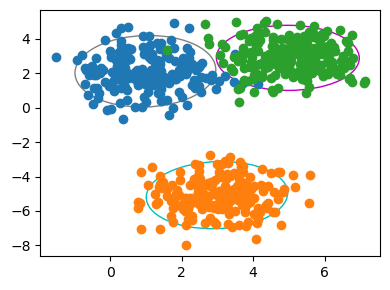

In [254]:
parts, gauss = iterate_gaussian_mixture_once(data, parts, gauss)
fig, ax = mplt.subplots(1, 1, figsize=(4, 3))

for clt in clusters:
    ax.plot(clt[0], clt[1], 'o')

for i, g in enumerate(gauss):
    ell = confidence_ellipse(g, ax, ec=colors[i])
    ax.add_patch(ell)

fig.tight_layout()
# fig.show()